In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'experiments-edgepts/'

### Needed Constants and Variables

In [3]:
SURVEY_ZONE_MAPPING = {'30': (2, 2, 0), '22': (3, 1, 2), '2c': (2, 0, 0), '28': (2, 2, 1), '25': (3, 2, 1), '26': (3, 1, 1), '27': (3, 0, 1), '20': (2, 2, 2), '21': (3, 2, 2), '1e': (3, 1, 2), '23': (3, 0, 2), '24': (2, 0, 1), '29': (3, 2, 1), '1a': (3, 1, 3), '0': (1, 0, 3), '3': (3, 1, 0), '2': (3, 2, 0), '5': (1, 0, 0), '1d': (3, 2, 2), '7': (2, 1, 1), '1f': (3, 0, 2), '9': (3, 1, 1), '8': (3, 2, 1), '3a': (3, 1, 3), '1c': (2, 0, 2), '4': (3, 0, 0), 'a': (3, 0, 1), '6': (1, 0, 1), '39': (3, 2, 3), '12': (1, 0, 2), '3b': (3, 0, 3), '1b': (3, 0, 3), 'b': (1, 0, 2), '13': (1, 0, 2), 'd': (3, 2, 2), '11': (1, 0, 3), '10': (1, 0, 3), 'c': (2, 1, 2), '38': (2, 0, 3), '15': (1, 0, 1), '14': (1, 0, 1), '17': (1, 0, 0), 'f': (3, 0, 2), '19': (3, 2, 3), '32': (3, 1, 0), '31': (3, 2, 0), '16': (1, 0, 0), '37': (3, 0, 3), '36': (3, 1, 3), '35': (3, 2, 3), '34': (2, 1, 3), '2d': (3, 2, 0), '2e': (3, 1, 0), '2f': (3, 0, 0), '1': (2, 1, 0), '2a': (3, 1, 1), '2b': (3, 0, 1), '18': (2, 2, 3), '33': (3, 0, 0), 'e': (3, 1, 2)}

In [4]:
_demands = [
    450,
    900,
    (450, 900),
    (900, 1800)
]

_weights = [
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (0.5, 0.5, 0),
    (0, 0.5, 0.5),
    (0.5, 0, 0.5),
    (0.33, 0.33, 0.33),
    (0, 0, 0)
]

_model_type = {
    (1, 0, 0): 'Delay priority',
    (0, 1, 0): 'Throughput priority',
    (0, 0, 1): 'Flow priority',
    (0.5, 0.5, 0): 'Delay-Throughput priority',
    (0, 0.5, 0.5): 'Throughput-Flow priority',
    (0.5, 0, 0.5): 'Delay-Flow priority',
    (0.33, 0.33, 0.33): 'Equal priority',
    (0, 0, 0): 'Parent model',
}

cols = [
    'Delay priority',
    'Throughput priority',
    'Flow priority',
    'Delay-Throughput priority',
    'Throughput-Flow priority',
    'Delay-Flow priority',
    'Equal priority',
    'Parent model'
]

In [5]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 0.25,
    'r_through': 0.5,
    'r_right': 0.25,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20,
    'flow_rate_reduction': 1
}


## Loading dataframes

In [25]:
# Results of the MILP solver only (Expected)

df_milp = pd.read_pickle(DF_PATH + 'milp-realtime-results.pkl')

df_milp.head()

,runtime,delay,throughput,objective_value,demand,new_model,alpha,beta,gamma,model_type,epoch
0,165.827293,3069.088608,51.278481,709.539027,450,True,1.00,0.00,0.00,Delay priority,0
5,596.403170,3069.088608,51.278481,-666.881330,450,True,0.50,0.00,0.50,Delay-Flow priority,0
3,539.389628,3069.088608,51.278481,258.865157,450,True,0.50,0.50,0.00,Delay-Throughput priority,0
6,833.726650,3069.088608,51.278481,-503.438553,450,True,0.33,0.33,0.33,Equal priority,0
2,673.527163,3265.265823,52.278481,-2055.801688,450,False,0.00,0.00,1.00,Flow priority,0


In [26]:
# Results of the LocalSim simulator only (Actual)

df_ave_delay = pd.read_pickle(DF_PATH + 'ave_delay.pkl')
df_total_delay = pd.read_pickle(DF_PATH + 'total_delay.pkl')
df_total_thru = pd.read_pickle(DF_PATH + 'total_throughput.pkl')

df_total_thru.head()

level_1,"(1, 0, 0)","(1, 0, 1)","(1, 0, 2)","(1, 0, 3)",demand,new_model,alpha,beta,gamma,model_type
0,1039.0,1051.0,1075.0,957.0,450,True,1.0,0.0,0.0,Delay priority
1,915.0,1126.0,1157.0,1024.0,450,True,0.0,1.0,0.0,Throughput priority
2,1041.0,964.0,1049.0,1087.0,450,True,0.0,0.0,1.0,Flow priority
3,998.0,998.0,1099.0,1071.0,450,True,0.5,0.5,0.0,Delay-Throughput priority
4,1082.0,885.0,1118.0,1027.0,450,True,0.0,0.5,0.5,Throughput-Flow priority


In [27]:
# Comparing computed and measured values (Expected vs Actual)

df_delay_comp = pd.read_pickle(DF_PATH + 'delay_comparison.pkl')
df_thru_comp = pd.read_pickle(DF_PATH + 'throughput_comparison.pkl')

df_delay_comp.head()

,demand,model_type,expected,actual,epoch
95,450,Delay priority,3069.088608,593.394878,0
94,450,Delay priority,7006.430380,5322.015216,1
93,450,Delay priority,8527.316456,8380.821153,2
92,450,Throughput priority,3500.000000,594.768753,0
91,450,Throughput priority,9228.835443,6945.216995,1


## Checking actual delay in the 32 cases

In [28]:
df_total_delay['total_delay'] = df_total_delay.iloc[:, :24].sum(axis=1)
df_total_delay_table = df_total_delay.pivot(index='demand', columns='model_type', values='total_delay')[cols]

df_total_delay_table = df_total_delay_table.apply(lambda x: x / 3600)

print("Total actual delay over 10 minutes (in vehicle-hours)")
df_total_delay_table.round(2)

Total actual delay over 10 minutes (in vehicle-hours)


model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,20.67,29.79,27.88,20.73,27.61,26.34,25.97,6.36
900,84.67,82.81,83.13,88.50,86.93,89.75,85.48,33.16
"(450, 900)",49.71,55.77,58.48,52.37,60.57,48.57,50.18,13.98
"(900, 1800)",89.18,94.31,93.66,88.97,92.14,93.75,92.37,44.46


In [29]:
df_delay_percent = (df_total_delay_table.iloc[:, :-1] - df_total_delay_table[['Parent model']].values) * -100 / df_total_delay_table[['Parent model']].values
#df_total_thru_table[['Parent model']]

df_delay_percent#.mean(axis=1).mean()

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority
demand,,,,,,,
450,-224.776753,-368.008690,-337.986880,-225.674460,-333.819758,-313.833383,-307.992873
900,-155.321891,-149.713839,-150.665626,-166.875346,-162.128458,-170.628228,-157.761209
"(450, 900)",-255.705966,-299.061258,-318.435594,-274.751294,-333.369693,-247.509024,-259.061242
"(900, 1800)",-100.589699,-112.137974,-110.677275,-100.132096,-107.253597,-110.882240,-107.777608


## Checking actual throughput in the 32 cases

In [30]:
df_total_thru['total_throughput'] = df_total_thru.iloc[:, :4].sum(axis=1)
df_total_thru_table = df_total_thru.pivot(index='demand', columns='model_type', values='total_throughput')[cols]

print("Total actual throughput over 10 minutes (in vehicles)")
df_total_thru_table

Total actual throughput over 10 minutes (in vehicles)


model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,4122.0,4222.0,4141.0,4166.0,4112.0,3991.0,4230.0,3408.0
900,5867.0,5655.0,5729.0,5893.0,5876.0,5942.0,5824.0,6776.0
"(450, 900)",5129.0,5295.0,5114.0,4913.0,5239.0,5120.0,4960.0,4861.0
"(900, 1800)",5896.0,5789.0,5909.0,5784.0,5790.0,5873.0,5969.0,6857.0


## By what percent?

In [16]:
df_thru_percent = (df_total_thru_table.iloc[:, :-1] - df_total_thru_table[['Parent model']].values) * 100 / df_total_thru_table[['Parent model']].values
#df_total_thru_table[['Parent model']]

df_thru_percent.round(2)#.mean(axis=1)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority
demand,,,,,,,
450,-1.13,-2.93,8.12,1.57,1.16,6.32,3.52
900,-10.98,4.33,-8.06,-0.16,-5.60,-6.63,-10.65
"(450, 900)",-0.87,0.38,-7.77,-0.66,-8.43,-12.25,-9.58
"(900, 1800)",4.52,5.19,0.75,-1.30,-1.88,-4.40,-3.94


## Checking initial computation runtime in the 32 cases

In [17]:
df_milp[df_milp.epoch == 0].pivot(index='demand', columns='model_type', values='runtime')[cols].round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,746.31,258.46,596.39,1129.75,426.15,1736.45,1369.60,301.05
900,133.55,122.55,464.02,222.94,379.94,353.23,357.95,167.33
"(450, 900)",175.19,149.50,348.47,190.07,93.08,252.71,256.77,73.68
"(900, 1800)",7.95,11.30,2.37,9.33,2.45,3.01,4.02,11.12


## Checking recomputation runtime in the 32 cases (average across epochs)

In [18]:
df_milp[df_milp.epoch != 0].pivot_table(index='demand', columns='model_type', values='runtime', aggfunc='mean')[cols].round(2)

model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,1.54,1.29,0.56,2.03,0.66,1.93,1.80,70.04
900,1.48,0.52,0.34,1.62,0.60,1.79,1.79,69.34
"(450, 900)",1.64,0.53,0.77,1.54,74.03,2.12,1.89,69.33
"(900, 1800)",1.58,0.62,0.48,1.51,0.46,2.68,2.86,74.91


## Checking error of computed and measured delay

In [20]:
df_delay_comp['error'] = df_delay_comp.apply(lambda row: (row.expected - row.actual) * 100 / (row.expected), axis=1)
df_delay_error = df_delay_comp.pivot_table(index='demand', columns='model_type', values='error', aggfunc=np.mean)[cols]

print("Percent error of delay")
df_delay_error

Percent error of delay


model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,7.251685,20.960473,11.772705,12.545657,3.837785,6.017405,1.719148,-1.507621
900,-30.093774,-21.591774,-26.000157,-27.055457,-17.222730,-31.169035,-28.256851,-35.525700
"(450, 900)",-7.441031,5.263909,-13.392760,-3.541883,-0.103426,-11.777948,-1.662644,-27.473012
"(900, 1800)",-5.738349,-5.500028,5.666979,8.108155,-4.711163,-4.325532,-4.982926,-8.113141


## Checking error of computed and measured throughput

In [21]:
df_thru_comp['error'] = df_thru_comp.apply(lambda row: (row.expected - row.actual) * 100 / (row.expected), axis=1)
df_thru_error = df_thru_comp.pivot_table(index='demand', columns='model_type', values='error', aggfunc=np.mean)[cols]

print("Percent error of throughput")
df_thru_error

Percent error of throughput


model_type,Delay priority,Throughput priority,Flow priority,Delay-Throughput priority,Throughput-Flow priority,Delay-Flow priority,Equal priority,Parent model
demand,,,,,,,,
450,-375.778982,-347.374975,-434.833768,-386.318543,-390.511035,-409.445557,-396.598641,-172.165494
900,-449.358165,-553.435314,-487.945037,-503.892537,-476.182074,-457.200961,-433.500148,-261.611490
"(450, 900)",-517.502445,-522.834213,-474.427749,-498.407165,-446.679657,-407.415465,-431.091547,-248.868816
"(900, 1800)",-511.469765,-530.130665,-521.659050,-484.745644,-492.986368,-469.123066,-469.701151,-230.640353


## Plot of cumulative delay (lower curve is better)

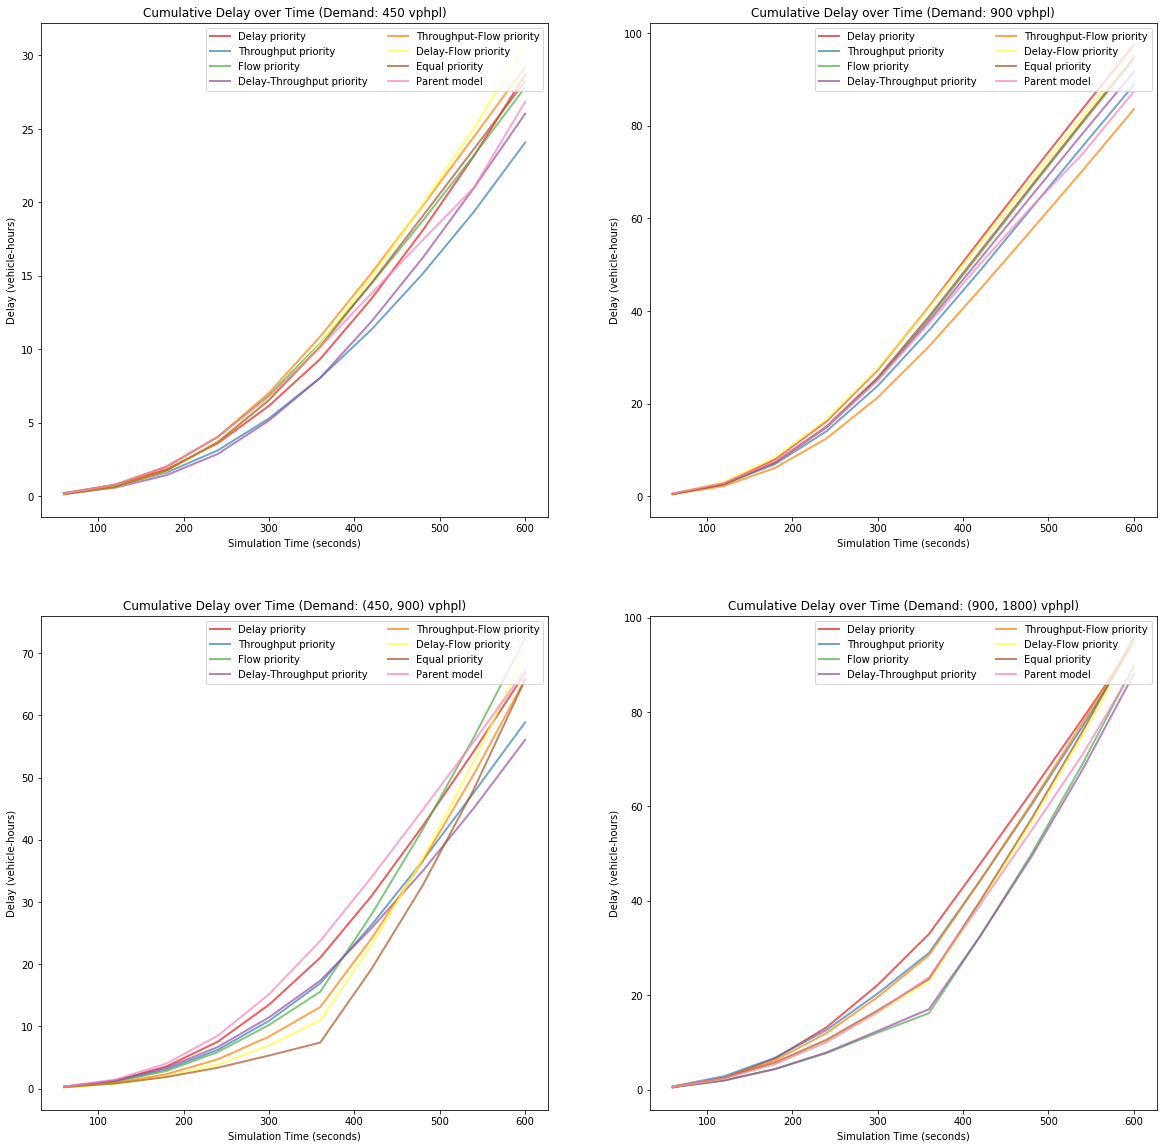

In [22]:
fig, axs = plt.subplots(2,2,figsize=(20,20))

for ndx, demand in enumerate(_demands):

    df_cumudelays = pd.DataFrame(index=[x for x in range(60,601,60)])

    for weights in _weights:
        df_tmp = pd.read_pickle(DF_PATH + 'cumu-delay/delay_d{}_a{}_b{}_c{}.pkl'.format(demand, *weights))
        df_cumudelays[_model_type[weights]] = df_tmp.iloc[:, 4:].sum(axis=1).apply(lambda x: x / 3600)
        
    palette = plt.get_cmap('Set1')
    num=0

    for column in df_cumudelays:
        axs[ndx / 2, ndx % 2].plot(df_cumudelays.index, df_cumudelays[column], marker='', color=palette(num), linewidth=2, alpha=0.7, label=column)
        num+=1

    # Add legend
    axs[ndx / 2, ndx % 2].legend(loc=1, ncol=2)

    # Add titles
    axs[ndx / 2, ndx % 2].set_title("Cumulative Delay over Time (Demand: {} vphpl)".format(demand))
    axs[ndx / 2, ndx % 2].set_xlabel("Simulation Time (seconds)")
    axs[ndx / 2, ndx % 2].set_ylabel("Delay (vehicle-hours)")

## Plot of cumulative throughput (higher is better)

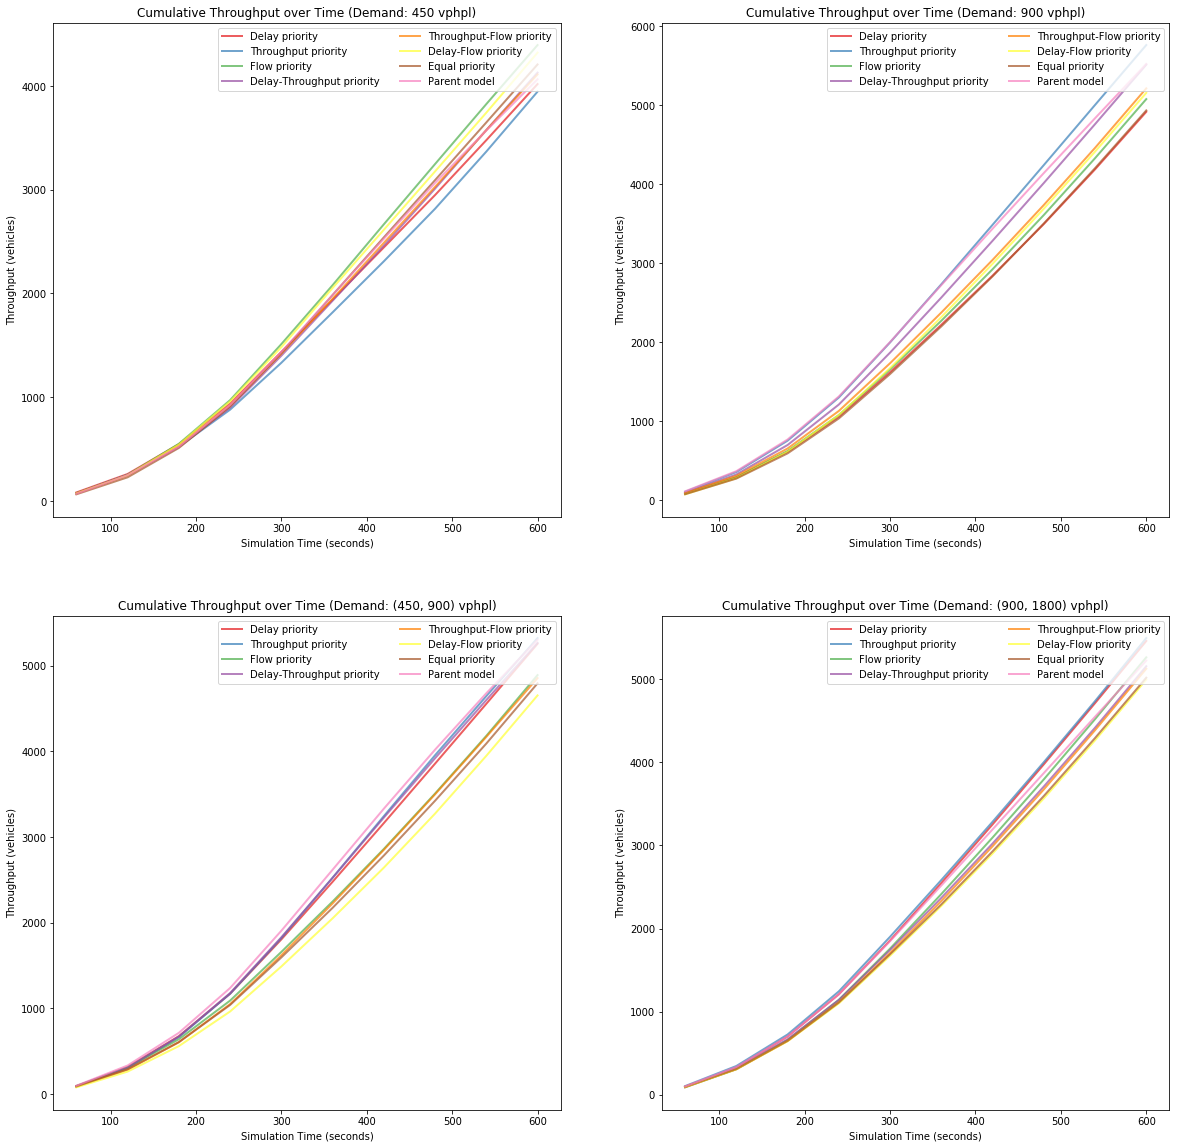

In [23]:
fig, axs = plt.subplots(2,2,figsize=(20,20))

for ndx, demand in enumerate(_demands):

    df_cumuthrus = pd.DataFrame(index=[x for x in range(60,601,60)])

    for weights in _weights:
        df_tmp = pd.read_pickle(DF_PATH + 'cumu-thru/thru_d{}_a{}_b{}_c{}.pkl'.format(demand, *weights))
        df_cumuthrus[_model_type[weights]] = df_tmp.sum(axis=1)
        
    palette = plt.get_cmap('Set1')
    num=0

    for column in df_cumuthrus:
        axs[ndx / 2, ndx % 2].plot(df_cumuthrus.index, df_cumuthrus[column], marker='', color=palette(num), linewidth=2, alpha=0.7, label=column)
        num+=1

    # Add legend
    axs[ndx / 2, ndx % 2].legend(loc=1, ncol=2)

    # Add titles
    axs[ndx / 2, ndx % 2].set_title("Cumulative Throughput over Time (Demand: {} vphpl)".format(demand))
    axs[ndx / 2, ndx % 2].set_xlabel("Simulation Time (seconds)")
    axs[ndx / 2, ndx % 2].set_ylabel("Throughput (vehicles)")